In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [3]:
# stack_fixed = 'LM30'
stack_fixed = 'LM40'
stack_moving = 'atlasV5'

In [4]:
detector_id = 15
warp_setting = 20
# warp_setting = 16

In [11]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment
warp_id,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000,2000,2000,30,0,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100,100,100,30,0,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0,0.000001,NaN
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,inverse,0.000000,NaN
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000,NaN
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200,200,200,30,inverse,0.000000,align mid-sagittal planes
9,8,rigid,0.000001,100000.0,10000.0,2000,2000,2000,30,NaN,NaN,global registration given mid-sagittal planes ...
18,8,affine,0.000001,100000.0,10000.0,200,200,200,30,NaN,NaN,global registration given mid-sagittal planes ...


In [12]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                                None
transform_type                                affine
terminate_thresh                               0.001
grad_computation_sample_number                100000
grid_search_sample_number                       1000
std_tx_um                                       2000
std_ty_um                                       2000
std_tz_um                                       2000
std_theta_xy_degree                               30
surround_weight                                  NaN
regularization_weight                            NaN
comment                           global reg no surr
Name: 20, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [13]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [13]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp"
(356, 427, 375)


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp'
Volume shape: (356, 427, 375)


In [14]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp
Score volume for 5N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp
Score volume for 5N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp
Score volume for 7N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp
Score volume for 7N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp
Score volume for 7n_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp
Score volume for 7n_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp
Score volume for Amb_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp
Score volume for LRt_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp
Score volume for LRt_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp
Score volume for Sp5C_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp
Score volume for Sp5C_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp
Score volume for Sp5I_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp
Score volume for Sp5I_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp
Score volume for Sp5O_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp"
(80, 63, 90)


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp'
Volume shape: (80, 63, 90)


In [16]:
structure_subset = all_known_structures_sided

In [17]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [18]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [19]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [20]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [21]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [22]:
label_weights_m

{4: 1.0, 30: 1.0, 36: 1.0}

In [23]:
from registration_utilities import *

In [24]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [25]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', indices_m=[structure_to_label_moving['SNR_L']])

centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [ 34.92947925  45.68563716  32.04813857]


In [26]:
aligner.set_label_weights(label_weights=label_weights_m)

In [27]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [28]:
gradient_filepath_map_f

{1: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 3: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp'}

In [29]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3])
load gradient 1: 0.015117 seconds
load gradient 2: 0.013834 seconds
load gradient 3: 0.013799 seconds
overall: 0.042905 seconds


In [30]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=0,
#                                     init_T=grid_search_T, 
                                     affine_scaling_limits=(.9, 1.2))
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.02 s
36: use 100000 samples out of 302006 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 51705 samples out of 51705 valid
sample: 0.05 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: 0.00 0.00 0.00, out T: -2.87 -2.12 -9.84
step: 0.25 seconds
current score: -0.166878
new_T: [-2.87283523 -2.11703967 -9.83862221]
det: 1.00

iteration 1
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.0

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -1.19 7.05 -16.78, out T: 1.43 7.92 -16.96
step: 0.26 seconds
current score: -0.220723
new_T: [  1.42765546   7.92462426 -16.96008557]
det: 1.00

iteration 10
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 212179 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 79393 samples out of 79393 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: 1.43 7.92 -16.96, out T: -

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.30 8.21 -19.38, out T: -0.65 8.45 -20.25
step: 0.27 seconds
current score: -0.248549
new_T: [ -0.64540619   8.44755295 -20.24922673]
det: 1.00

iteration 20
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 340 samples out of 340 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195634 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -0.60 8.58 -22.11, out T: -0.15 8.58 -21.38
step: 0.27 seconds
current score: -0.259804
new_T: [ -0.15471275   8.57754024 -21.37711835]
det: 1.00

iteration 28
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 480 samples out of 480 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190629 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.80 7.67 -20.64, out T: -2.76 7.01 -19.99
step: 0.27 seconds
current score: -0.248560
new_T: [ -2.75879953   7.00659018 -19.98624483]
det: 1.00

iteration 36
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 304 samples out of 304 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 201495 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -1.57 7.01 -22.05, out T: -0.58 6.51 -21.57
step: 0.27 seconds
current score: -0.252822
new_T: [ -0.57738183   6.50592846 -21.5681149 ]
det: 1.00

iteration 44
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 408 samples out of 408 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 196937 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -1.46 4.05 -18.44, out T: -1.14 3.60 -18.48
step: 0.27 seconds
current score: -0.215541
new_T: [ -1.14451282   3.59515798 -18.48392716]
det: 1.00

iteration 52
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 219486 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 83142 samples out of 83142 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -1.14 3.60 -18.48, out T:

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.26 1.78 -16.73, out T: -2.60 2.32 -16.32
step: 0.27 seconds
current score: -0.207066
new_T: [ -2.60248003   2.31533627 -16.32356588]
det: 1.00

iteration 62
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 230439 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 81741 samples out of 81741 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.60 2.32 -16.32, out T:

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.36 4.24 -18.93, out T: -3.18 5.57 -19.15
step: 0.27 seconds
current score: -0.237507
new_T: [ -3.17696817   5.56995859 -19.15377695]
det: 1.00

iteration 71
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 133 samples out of 133 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 208975 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.15 5.14 -19.60, out T: -5.55 5.53 -20.08
step: 0.27 seconds
current score: -0.236874
new_T: [ -5.54545857   5.53065828 -20.08218327]
det: 1.00

iteration 79
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 308 samples out of 308 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 202444 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.99 5.06 -20.26, out T: -6.45 5.11 -20.99
step: 0.28 seconds
current score: -0.240331
new_T: [ -6.45253454   5.10682539 -20.99144558]
det: 1.00

iteration 87
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 396 samples out of 396 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 199996 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.35 4.97 -19.57, out T: -4.83 4.81 -20.18
step: 0.27 seconds
current score: -0.236874
new_T: [ -4.83123394   4.81431453 -20.1782556 ]
det: 1.00

iteration 95
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 252 samples out of 252 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 205595 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
f

sample: 0.10 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.66 6.03 -21.71, out T: -7.59 6.52 -21.50
step: 0.28 seconds
current score: -0.248269
new_T: [ -7.59044712   6.51827269 -21.49539655]
det: 1.00

iteration 103
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 576 samples out of 576 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 193527 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.59 7.51 -21.65, out T: -8.83 7.58 -21.28
step: 0.28 seconds
current score: -0.252753
new_T: [ -8.82833833   7.57636672 -21.2794901 ]
det: 1.00

iteration 111
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 675 samples out of 675 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190104 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.65 7.77 -21.01, out T: -8.68 7.34 -21.37
step: 0.28 seconds
current score: -0.252753
new_T: [ -8.67804781   7.34256449 -21.36749235]
det: 1.00

iteration 119
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 675 samples out of 675 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190104 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.10 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.19 6.05 -23.23, out T: -7.88 6.18 -23.64
step: 0.28 seconds
current score: -0.251244
new_T: [ -7.88085816   6.18269563 -23.6446688 ]
det: 1.00

iteration 127
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 960 samples out of 960 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 183986 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.10 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.33 6.71 -22.81, out T: -11.83 6.69 -22.47
step: 0.28 seconds
current score: -0.258004
new_T: [-11.83429671   6.68783264 -22.47342317]
det: 1.00

iteration 135
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 896 samples out of 896 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 181961 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -13.19 4.54 -18.41, out T: -12.31 3.93 -18.98
step: 0.27 seconds
current score: -0.227325
new_T: [-12.31433558   3.9320005  -18.97560366]
det: 1.00

iteration 143
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 140 samples out of 140 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 201482 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.79 8.22 -21.40, out T: -6.88 8.33 -22.11
step: 0.28 seconds
current score: -0.252460
new_T: [ -6.87870644   8.32748731 -22.11418019]
det: 1.00

iteration 151
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 920 samples out of 920 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 184516 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.13 10.68 -21.67, out T: -8.78 9.56 -20.29
step: 0.28 seconds
current score: -0.260484
new_T: [ -8.77500885   9.55653505 -20.28580045]
det: 1.00

iteration 159
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 550 samples out of 550 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189726 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.91 10.59 -19.69, out T: -10.70 9.44 -19.60
step: 0.27 seconds
current score: -0.255783
new_T: [-10.69973463   9.4437498  -19.59796442]
det: 1.00

iteration 167
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 297 samples out of 297 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190651 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.80 8.08 -21.03, out T: -14.61 7.77 -20.67
step: 0.28 seconds
current score: -0.262647
new_T: [-14.61329538   7.76831645 -20.66760822]
det: 1.00

iteration 175
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 837 samples out of 837 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 178205 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.61 5.81 -18.31, out T: -14.40 5.85 -18.45
step: 0.27 seconds
current score: -0.233917
new_T: [-14.40396758   5.84792509 -18.44901892]
det: 1.00

iteration 183
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 197639 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.40 5.85 -18.45, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.03 6.52 -19.20, out T: -14.56 5.72 -17.98
step: 0.27 seconds
current score: -0.253638
new_T: [-14.55786334   5.72312885 -17.98024908]
det: 1.00

iteration 192
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195254 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.56 5.72 -17.98, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -13.69 5.83 -18.50, out T: -15.24 6.19 -19.48
step: 0.27 seconds
current score: -0.231529
new_T: [-15.237922     6.19273175 -19.47891922]
det: 1.00

iteration 201
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 248 samples out of 248 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189022 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.28 7.07 -18.57, out T: -13.81 6.99 -18.18
step: 0.27 seconds
current score: -0.228958
new_T: [-13.80945181   6.99245391 -18.17654633]
det: 1.00

iteration 209
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195702 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -13.81 6.99 -18.18, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.78 7.68 -18.79, out T: -14.35 7.92 -18.99
step: 0.27 seconds
current score: -0.257897
new_T: [-14.35312516   7.91688327 -18.98883528]
det: 1.00

iteration 218
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 270 samples out of 270 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189196 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.62 8.06 -18.89, out T: -16.78 8.25 -17.80
step: 0.27 seconds
current score: -0.262439
new_T: [-16.77704747   8.24768432 -17.79629949]
det: 1.00

iteration 226
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 184640 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.78 8.25 -17.80, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.51 7.62 -17.81, out T: -16.39 8.23 -18.17
step: 0.27 seconds
current score: -0.242497
new_T: [-16.38505406   8.23205146 -18.16613409]
det: 1.00

iteration 235
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186938 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.39 8.23 -18.17, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.21 7.39 -19.17, out T: -17.00 6.73 -18.74
step: 0.27 seconds
current score: -0.260145
new_T: [-16.99548423   6.72850147 -18.7402276 ]
det: 1.00

iteration 243
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 264 samples out of 264 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 184343 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -17.22 7.65 -18.60, out T: -16.82 7.63 -18.85
step: 0.27 seconds
current score: -0.242497
new_T: [-16.82294445   7.63439569 -18.85112117]
det: 1.00

iteration 252
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 297 samples out of 297 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 182431 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -15.76 7.76 -19.66, out T: -16.19 7.66 -19.85
step: 0.28 seconds
current score: -0.260145
new_T: [-16.18821809   7.65717489 -19.84901914]
det: 1.00

iteration 260
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 576 samples out of 576 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 180405 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -14.89 8.15 -19.44, out T: -16.31 7.94 -19.71
step: 0.27 seconds
current score: -0.260024
new_T: [-16.30583772   7.93933261 -19.70704459]
det: 1.00

iteration 268
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 576 samples out of 576 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 180405 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.38 8.27 -18.14, out T: -16.86 7.70 -18.45
step: 0.27 seconds
current score: -0.242229
new_T: [-16.85747238   7.70183273 -18.44696442]
det: 1.00

iteration 276
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186676 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.86 7.70 -18.45, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -16.09 7.61 -19.76, out T: -15.33 6.93 -19.04
step: 0.28 seconds
current score: -0.262430
new_T: [-15.33484552   6.93060564 -19.04447374]
det: 1.00

iteration 284
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 248 samples out of 248 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189022 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -13.85 7.37 -19.09, out T: -13.00 6.56 -19.48
step: 0.27 seconds
current score: -0.255700
new_T: [-13.00276286   6.56050625 -19.48137198]
det: 1.00

iteration 292
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 232 samples out of 232 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 193507 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.84 8.01 -19.98, out T: -11.72 8.33 -20.43
step: 0.28 seconds
current score: -0.253988
new_T: [-11.72431825   8.33103824 -20.42910102]
det: 1.00

iteration 300
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 560 samples out of 560 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186583 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.02 8.38 -20.64, out T: -9.93 8.33 -20.89
step: 0.27 seconds
current score: -0.254325
new_T: [ -9.9310261    8.33146448 -20.89367632]
det: 1.00

iteration 308
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 780 samples out of 780 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 185787 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.26 9.64 -20.22, out T: -9.01 9.39 -20.24
step: 0.28 seconds
current score: -0.254922
new_T: [ -9.01244444   9.3883905  -20.23769783]
det: 1.00

iteration 316
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 550 samples out of 550 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189726 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.19 10.33 -20.31, out T: -7.71 9.47 -20.22
step: 0.27 seconds
current score: -0.255148
new_T: [ -7.71081974   9.47111993 -20.22160065]
det: 1.00

iteration 324
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 528 samples out of 528 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190568 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.07 8.68 -18.40, out T: -7.84 9.24 -17.75
step: 0.27 seconds
current score: -0.226508
new_T: [ -7.84282087   9.24459074 -17.7515149 ]
det: 1.00

iteration 332
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 199962 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.84 9.24 -17.75, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.29 7.96 -17.53, out T: -4.06 7.53 -16.90
step: 0.27 seconds
current score: -0.221282
new_T: [ -4.06060572   7.53478448 -16.90361704]
det: 1.00

iteration 342
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 212568 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 84320 samples out of 84320 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.06 7.53 -16.90, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.93 7.64 -17.71, out T: -2.98 8.19 -17.74
step: 0.27 seconds
current score: -0.224897
new_T: [ -2.98440827   8.19440949 -17.74295002]
det: 1.00

iteration 352
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 205156 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85128 samples out of 85128 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.98 8.19 -17.74, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.05 8.39 -16.44, out T: -4.68 8.85 -15.51
step: 0.26 seconds
current score: -0.221284
new_T: [ -4.68047192   8.85450118 -15.50703956]
det: 1.00

iteration 362
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 218593 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 81583 samples out of 81583 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.68 8.85 -15.51, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.45 10.99 -17.85, out T: -5.04 10.83 -17.83
step: 0.27 seconds
current score: -0.232653
new_T: [ -5.03861854  10.83053174 -17.8310945 ]
det: 1.00

iteration 372
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 198642 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86874 samples out of 86874 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.04 10.83 -17.83, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.26 11.45 -18.13, out T: -4.19 11.57 -18.47
step: 0.26 seconds
current score: -0.236487
new_T: [ -4.19290377  11.57485604 -18.46994884]
det: 1.00

iteration 381
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195650 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86032 samples out of 86032 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.19 11.57 -18.47, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.26 9.46 -18.07, out T: -6.00 9.77 -18.27
step: 0.27 seconds
current score: -0.229293
new_T: [ -5.99926806   9.766641   -18.27190527]
det: 1.00

iteration 391
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 201236 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87640 samples out of 87640 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.00 9.77 -18.27, out T

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.68 9.40 -18.39, out T: -7.17 9.28 -18.18
step: 0.27 seconds
current score: -0.229160
new_T: [ -7.17371556   9.27568678 -18.17646557]
det: 1.00

iteration 399
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 200661 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 88348 samples out of 88348 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.17 9.28 -18.18, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.66 8.85 -17.44, out T: -6.37 9.12 -17.76
step: 0.27 seconds
current score: -0.223529
new_T: [ -6.36852056   9.11970843 -17.75719011]
det: 1.00

iteration 409
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 204086 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87640 samples out of 87640 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.37 9.12 -17.76, out T

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.48 8.54 -19.58, out T: -6.11 8.98 -19.63
step: 0.27 seconds
current score: -0.246987
new_T: [ -6.11401694   8.97966783 -19.63199214]
det: 1.00

iteration 418
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 220 samples out of 220 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 199376 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.11 9.88 -19.64, out T: -6.33 9.93 -20.01
step: 0.27 seconds
current score: -0.249801
new_T: [ -6.3349089    9.92760585 -20.01454365]
det: 1.00

iteration 426
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 484 samples out of 484 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 191825 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.64 9.90 -20.41, out T: -5.64 9.93 -20.47
step: 0.27 seconds
current score: -0.252568
new_T: [ -5.63693303   9.93179757 -20.46648391]
det: 1.00

iteration 434
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 484 samples out of 484 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 191825 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.98 9.40 -20.37, out T: -6.43 10.02 -20.69
step: 0.27 seconds
current score: -0.252351
new_T: [ -6.43172677  10.0193596  -20.68542501]
det: 1.00

iteration 442
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 726 samples out of 726 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 187100 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.78 9.86 -20.67, out T: -4.87 9.71 -20.14
step: 0.27 seconds
current score: -0.255378
new_T: [ -4.86922088   9.7125912  -20.1419492 ]
det: 1.00

iteration 450
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 462 samples out of 462 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 192257 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.70 8.21 -20.02, out T: -6.27 8.98 -20.29
step: 0.27 seconds
current score: -0.249651
new_T: [ -6.26745437   8.97934796 -20.29149848]
det: 1.00

iteration 458
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 440 samples out of 440 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 194644 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.73 8.14 -18.88, out T: -6.34 8.00 -19.00
step: 0.27 seconds
current score: -0.246987
new_T: [ -6.34006675   7.99746587 -19.00448823]
det: 1.00

iteration 466
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 198 samples out of 198 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 202118 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s


sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.12 7.10 -18.68, out T: -7.01 6.84 -18.21
step: 0.27 seconds
current score: -0.241723
new_T: [ -7.00906182   6.84428811 -18.20841631]
det: 1.00

iteration 474
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 208661 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 88348 samples out of 88348 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.01 6.84 -18.21, out T

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.80 7.12 -18.40, out T: -8.62 6.69 -18.42
step: 0.27 seconds
current score: -0.221436
new_T: [ -8.62435604   6.68980016 -18.42367495]
det: 1.00

iteration 483
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 206647 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.62 6.69 -18.42, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.80 7.15 -16.91, out T: -9.48 7.32 -17.26
step: 0.27 seconds
current score: -0.222076
new_T: [ -9.48183315   7.31605106 -17.25547036]
det: 1.00

iteration 493
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 208918 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87176 samples out of 87176 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.48 7.32 -17.26, out T

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.74 7.68 -17.67, out T: -10.13 7.74 -18.07
step: 0.27 seconds
current score: -0.226311
new_T: [-10.13332022   7.74009553 -18.07416899]
det: 1.00

iteration 503
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 202211 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.13 7.74 -18.07, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.08 6.66 -17.89, out T: -12.17 6.43 -17.92
step: 0.27 seconds
current score: -0.228958
new_T: [-12.16634862   6.43272541 -17.91553062]
det: 1.00

iteration 513
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 200209 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.17 6.43 -17.92, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.86 4.87 -17.64, out T: -13.25 5.00 -17.41
step: 0.27 seconds
current score: -0.224734
new_T: [-13.24679563   4.99634652 -17.4064163 ]
det: 1.00

iteration 523
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 206262 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87176 samples out of 87176 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -13.25 5.00 -17.41, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.94 5.94 -19.04, out T: -13.19 5.40 -18.69
step: 0.27 seconds
current score: -0.249453
new_T: [-13.18637118   5.4020612  -18.69312706]
det: 1.00

iteration 532
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 203 samples out of 203 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195510 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -15.14 6.80 -19.25, out T: -15.12 7.22 -19.55
step: 0.27 seconds
current score: -0.255896
new_T: [-15.12220837   7.21508808 -19.54672574]
det: 1.00

iteration 540
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 279 samples out of 279 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186990 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -15.02 7.71 -19.52, out T: -14.95 7.94 -19.56
step: 0.27 seconds
current score: -0.257897
new_T: [-14.95149046   7.94077483 -19.55813911]
det: 1.00

iteration 548
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 279 samples out of 279 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186990 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -13.15 10.46 -20.42, out T: -13.41 10.16 -20.34
step: 0.27 seconds
current score: -0.262963
new_T: [-13.40784596  10.16022147 -20.34065995]
det: 1.00

iteration 556
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 696 samples out of 696 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 179751 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.0

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.22 10.85 -19.66, out T: -12.07 11.00 -19.65
step: 0.27 seconds
current score: -0.258669
new_T: [-12.0675775   10.99891977 -19.65020924]
det: 1.00

iteration 564
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 336 samples out of 336 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186161 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.0

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.60 10.82 -18.23, out T: -12.19 10.82 -18.13
step: 0.27 seconds
current score: -0.240481
new_T: [-12.19410517  10.82317164 -18.13160619]
det: 1.00

iteration 572
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190673 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -12.19 10.82 -18.13,

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.36 11.83 -18.64, out T: -11.86 11.35 -18.27
step: 0.27 seconds
current score: -0.239251
new_T: [-11.85787726  11.35004151 -18.27301377]
det: 1.00

iteration 580
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 188030 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.86 11.35 -18.27,

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.14 12.88 -18.95, out T: -10.98 13.04 -18.44
step: 0.27 seconds
current score: -0.262447
new_T: [-10.97627951  13.04109652 -18.43878896]
det: 1.00

iteration 590
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186856 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.98 13.04 -18.44,

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.53 13.80 -18.33, out T: -11.46 13.68 -17.96
step: 0.26 seconds
current score: -0.247192
new_T: [-11.45992518  13.68271314 -17.95963536]
det: 1.00

iteration 599
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 183739 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -11.46 13.68 -17.96,

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.90 13.38 -18.35, out T: -8.73 13.95 -18.66
step: 0.26 seconds
current score: -0.242035
new_T: [ -8.72860366  13.94755689 -18.66481804]
det: 1.00

iteration 609
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 187132 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.73 13.95 -18.66, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.02 13.55 -17.50, out T: -7.00 14.29 -17.61
step: 0.26 seconds
current score: -0.238915
new_T: [ -7.00423618  14.28924897 -17.61281081]
det: 1.00

iteration 618
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189241 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86549 samples out of 86549 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.00 14.29 -17.61, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.32 14.91 -17.79, out T: -7.24 15.09 -17.53
step: 0.26 seconds
current score: -0.245097
new_T: [ -7.23942342  15.08835544 -17.52708541]
det: 1.00

iteration 628
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 189241 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86549 samples out of 86549 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.24 15.09 -17.53, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.33 13.27 -17.20, out T: -5.82 13.16 -17.64
step: 0.26 seconds
current score: -0.239876
new_T: [ -5.82361221  13.15820577 -17.63816863]
det: 1.00

iteration 638
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 193006 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85869 samples out of 85869 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.82 13.16 -17.64, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.01 13.79 -18.62, out T: -6.15 13.88 -18.55
step: 0.27 seconds
current score: -0.242080
new_T: [ -6.1504359   13.87504038 -18.55428811]
det: 1.00

iteration 648
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 188449 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87640 samples out of 87640 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.15 13.88 -18.55, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.80 13.96 -17.92, out T: -5.35 14.28 -17.95
step: 0.26 seconds
current score: -0.242685
new_T: [ -5.3461494   14.28306164 -17.95236292]
det: 1.00

iteration 657
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 185066 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86874 samples out of 86874 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.35 14.28 -17.95, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.86 14.04 -17.36, out T: -4.39 14.25 -18.09
step: 0.26 seconds
current score: -0.239876
new_T: [ -4.39477503  14.24671568 -18.08915849]
det: 1.00

iteration 666
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 185014 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86032 samples out of 86032 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.39 14.25 -18.09, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.32 14.17 -16.38, out T: -6.01 13.96 -16.38
step: 0.26 seconds
current score: -0.240748
new_T: [ -6.00648014  13.95743023 -16.38362523]
det: 1.00

iteration 676
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 197546 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 84073 samples out of 84073 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.01 13.96 -16.38, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.32 13.57 -17.79, out T: -7.97 13.51 -17.90
step: 0.27 seconds
current score: -0.241674
new_T: [ -7.96635918  13.50691284 -17.90137383]
det: 1.00

iteration 686
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 187719 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.97 13.51 -17.90, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.65 14.02 -18.74, out T: -7.86 14.22 -18.74
step: 0.27 seconds
current score: -0.262236
new_T: [ -7.85963272  14.21805319 -18.73755553]
det: 1.00

iteration 696
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 384 samples out of 384 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 179826 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.22 12.00 -17.96, out T: -7.24 11.90 -17.83
step: 0.27 seconds
current score: -0.235009
new_T: [ -7.24428701  11.89960624 -17.82980443]
det: 1.00

iteration 705
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 194812 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 88348 samples out of 88348 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.24 11.90 -17.83, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.69 11.74 -18.24, out T: -7.52 11.17 -17.93
step: 0.27 seconds
current score: -0.234905
new_T: [ -7.51927798  11.16505247 -17.93457368]
det: 1.00

iteration 715
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 194262 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.52 11.17 -17.93, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.48 9.70 -17.72, out T: -7.73 10.08 -17.82
step: 0.27 seconds
current score: -0.229160
new_T: [ -7.73190159  10.07541766 -17.81776798]
det: 1.00

iteration 725
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 199962 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -7.73 10.08 -17.82, out

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.49 10.61 -17.99, out T: -6.59 10.59 -18.03
step: 0.27 seconds
current score: -0.232245
new_T: [ -6.58775397  10.58671785 -18.02667198]
det: 1.00

iteration 735
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 197785 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
30: use 88348 samples out of 88348 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.59 10.59 -18.03, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.63 10.55 -17.60, out T: -6.50 10.63 -17.61
step: 0.27 seconds
current score: -0.229179
new_T: [ -6.5018186   10.63461068 -17.60727098]
det: 1.00

iteration 745
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 202442 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86549 samples out of 86549 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.50 10.63 -17.61, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.89 10.04 -16.95, out T: -5.88 9.67 -17.09
step: 0.27 seconds
current score: -0.226391
new_T: [ -5.87686193   9.66656595 -17.0890156 ]
det: 1.00

iteration 755
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 205910 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85869 samples out of 85869 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.88 9.67 -17.09, out 

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.24 10.56 -17.69, out T: -4.57 10.24 -17.53
step: 0.26 seconds
current score: -0.233289
new_T: [ -4.56924656  10.24071138 -17.52546456]
det: 1.00

iteration 765
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 203300 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85132 samples out of 85132 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.57 10.24 -17.53, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.30 10.75 -18.62, out T: -5.69 10.86 -18.87
step: 0.27 seconds
current score: -0.232653
new_T: [ -5.68764021  10.86002292 -18.86973381]
det: 1.00

iteration 775
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 264 samples out of 264 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 193605 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.69 10.75 -18.19, out T: -6.78 10.50 -18.15
step: 0.27 seconds
current score: -0.232036
new_T: [ -6.77837618  10.50329191 -18.15366705]
det: 1.00

iteration 784
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 197785 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 88348 samples out of 88348 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.78 10.50 -18.15, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.61 10.88 -17.88, out T: -8.40 10.54 -17.58
step: 0.27 seconds
current score: -0.232788
new_T: [ -8.40142098  10.5400846  -17.5754959 ]
det: 1.00

iteration 794
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 201815 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87176 samples out of 87176 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -8.40 10.54 -17.58, ou

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.12 10.71 -18.59, out T: -9.11 10.26 -17.93
step: 0.27 seconds
current score: -0.232788
new_T: [ -9.10721997  10.25662993 -17.9280665 ]
det: 1.00

iteration 804
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 196379 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.11 10.26 -17.93, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.16 9.93 -17.50, out T: -9.85 9.82 -17.59
step: 0.27 seconds
current score: -0.229203
new_T: [ -9.84703417   9.82058717 -17.59176306]
det: 1.00

iteration 814
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 201791 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 87176 samples out of 87176 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.85 9.82 -17.59, out 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.46 10.06 -19.08, out T: -9.18 10.17 -19.23
step: 0.27 seconds
current score: -0.250465
new_T: [ -9.18434724  10.17393526 -19.23180987]
det: 1.00

iteration 824
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 300 samples out of 300 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 191710 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.20 10.33 -18.70, out T: -10.28 10.14 -18.43
step: 0.27 seconds
current score: -0.254950
new_T: [-10.28263285  10.14186753 -18.43147562]
det: 1.00

iteration 832
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 194521 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 89002 samples out of 89002 valid
sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -10.28 10.14 -18.43,

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -9.69 10.54 -19.12, out T: -8.82 10.76 -19.37
step: 0.27 seconds
current score: -0.254950
new_T: [ -8.81570466  10.75977019 -19.37224158]
det: 1.00

iteration 840
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 300 samples out of 300 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 191710 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.82 12.40 -19.21, out T: -6.79 12.26 -19.45
step: 0.27 seconds
current score: -0.258634
new_T: [ -6.79209636  12.25633598 -19.44950641]
det: 1.00

iteration 848
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 322 samples out of 322 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 186891 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.18 11.32 -19.90, out T: -5.84 11.72 -19.73
step: 0.27 seconds
current score: -0.258402
new_T: [ -5.84094679  11.71558947 -19.7250944 ]
det: 1.00

iteration 856
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 572 samples out of 572 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 185904 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -6.08 11.12 -19.21, out T: -5.86 11.02 -19.01
step: 0.27 seconds
current score: -0.252714
new_T: [ -5.86105992  11.0150431  -19.01088352]
det: 1.00

iteration 864
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 264 samples out of 264 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 193605 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -5.93 11.62 -18.89, out T: -5.62 12.20 -18.99
step: 0.27 seconds
current score: -0.255720
new_T: [ -5.6204183   12.20423852 -18.98755989]
det: 1.00

iteration 872
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 308 samples out of 308 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 187255 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.43 12.93 -19.30, out T: -4.69 12.93 -18.98
step: 0.27 seconds
current score: -0.260412
new_T: [ -4.69376273  12.93451537 -18.98476348]
det: 1.00

iteration 880
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 294 samples out of 294 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 187481 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.09 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.70 12.96 -19.33, out T: -4.27 13.48 -19.54
step: 0.27 seconds
current score: -0.259603
new_T: [ -4.27237956  13.48071636 -19.53706686]
det: 1.00

iteration 888
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 300 samples out of 300 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 184060 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.95 12.56 -17.89, out T: -3.91 12.08 -17.91
step: 0.27 seconds
current score: -0.239974
new_T: [ -3.90781718  12.08450112 -17.90872077]
det: 1.00

iteration 896
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195650 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86032 samples out of 86032 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.91 12.08 -17.91, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.55 12.38 -17.63, out T: -3.38 12.10 -17.73
step: 0.27 seconds
current score: -0.237098
new_T: [ -3.38133098  12.09597415 -17.72657578]
det: 1.00

iteration 906
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195619 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85128 samples out of 85128 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.38 12.10 -17.73, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.64 11.35 -17.03, out T: -2.30 11.45 -17.21
step: 0.27 seconds
current score: -0.234480
new_T: [ -2.29574519  11.45235573 -17.21128497]
det: 1.00

iteration 916
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 200035 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 82513 samples out of 82513 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.30 11.45 -17.21, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.45 12.66 -18.01, out T: -2.73 12.62 -17.47
step: 0.26 seconds
current score: -0.242197
new_T: [ -2.72847798  12.62014119 -17.46841105]
det: 1.00

iteration 926
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 196651 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 83447 samples out of 83447 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.73 12.62 -17.47, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.28 12.09 -17.41, out T: -3.71 11.72 -17.49
step: 0.26 seconds
current score: -0.234480
new_T: [ -3.71242891  11.72437865 -17.48892716]
det: 1.00

iteration 936
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 200282 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 84320 samples out of 84320 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.71 11.72 -17.49, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.58 11.56 -16.77, out T: -4.83 11.29 -16.99
step: 0.27 seconds
current score: -0.232881
new_T: [ -4.8257201   11.29288184 -16.9932263 ]
det: 1.00

iteration 946
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 200157 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85132 samples out of 85132 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.83 11.29 -16.99, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.28 11.85 -18.20, out T: -4.13 11.84 -18.05
step: 0.27 seconds
current score: -0.236487
new_T: [ -4.13387846  11.83696002 -18.04817381]
det: 1.00

iteration 956
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195650 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 86032 samples out of 86032 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -4.13 11.84 -18.05, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.44 11.76 -19.22, out T: -3.81 11.52 -18.84
step: 0.27 seconds
current score: -0.257960
new_T: [ -3.8053929   11.51698675 -18.8372605 ]
det: 1.00

iteration 965
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 260 samples out of 260 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 191000 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.82 11.88 -18.62, out T: -2.17 11.62 -18.31
step: 0.26 seconds
current score: -0.237422
new_T: [ -2.17289076  11.61656417 -18.31356025]
det: 1.00

iteration 974
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 195422 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 84163 samples out of 84163 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.17 11.62 -18.31, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -2.93 10.91 -18.66, out T: -3.07 10.75 -18.47
step: 0.27 seconds
current score: -0.234148
new_T: [ -3.07359778  10.74558726 -18.46994925]
det: 1.00

iteration 983
Error computing score: 4: No valid voxels after transform.
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 198893 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
30: use 85128 samples out of 85128 valid
sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.07 10.75 -18.47, ou

sample: 0.08 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
in T: -3.05 11.11 -18.46, out T: -2.87 11.62 -18.72
step: 0.26 seconds
current score: -0.234148
new_T: [ -2.86738022  11.62465945 -18.71889007]
det: 1.00

iteration 993
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.00 s
4: use 247 samples out of 247 valid
sample: 0.00 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 s
fancy indexing into centralized moving volume nzvoxels: 0.00 s
fancy indexing into fixed volume gradient: 0.01 s
36: use 100000 samples out of 190977 valid
sample: 0.11 s
compute gradient, all voxels: 0.01 s
compute gradient, sum: 0.00 s
fancy indexing into moving volume nz voxels: 0.00 s
fancy indexing into moving volume: 0.00 

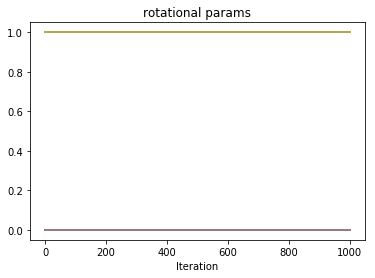

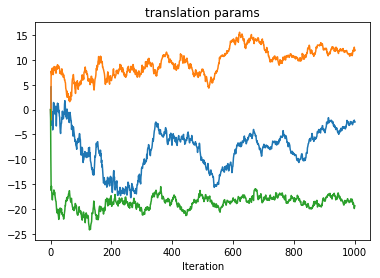

In [31]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.166878 -0.25796
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]


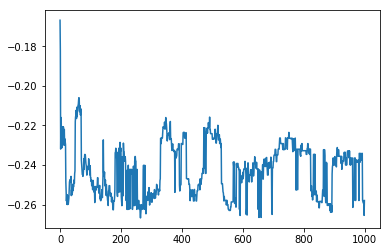

In [32]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [33]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [47]:
# Transform moving volume, sided, without surround

structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

In [49]:
label_mapping_m2f

{4: 1, 30: 2, 36: 3}

In [50]:
label_to_structure_fixed

{1: '3N_L', 2: 'RMC_L', 3: 'SNR_L'}

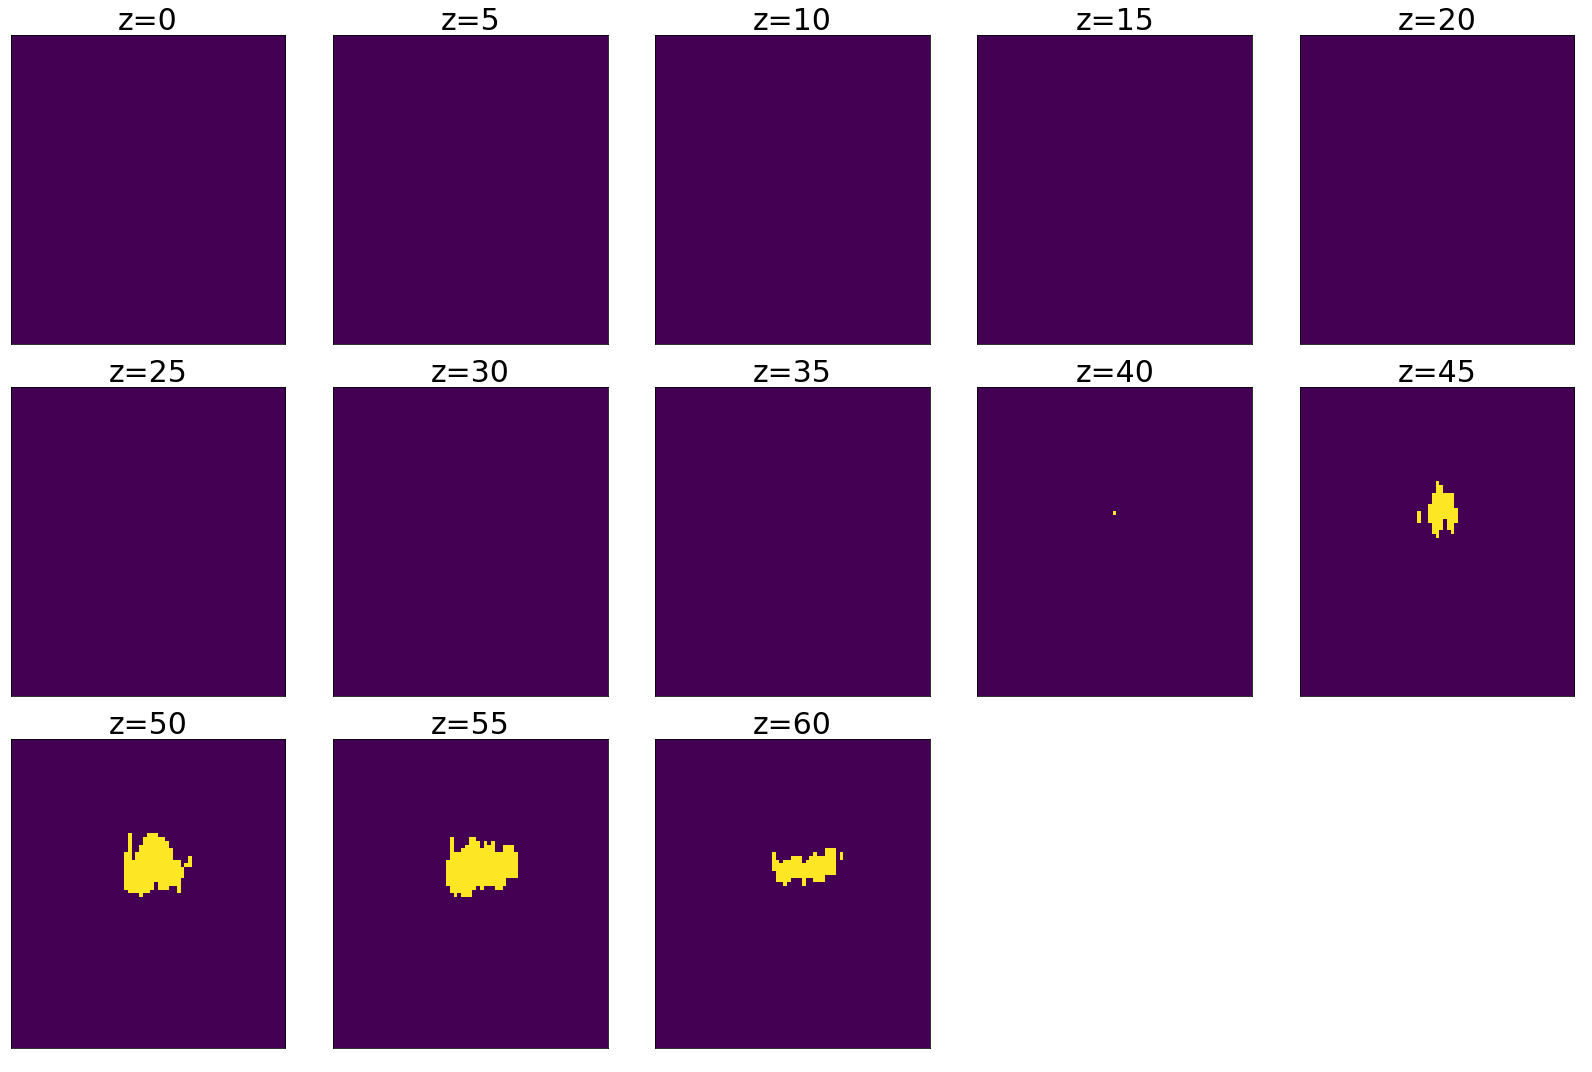

In [43]:
display_volume_sections(volume_fixed[2], start_level=0)

In [40]:
from utilities2015 import *

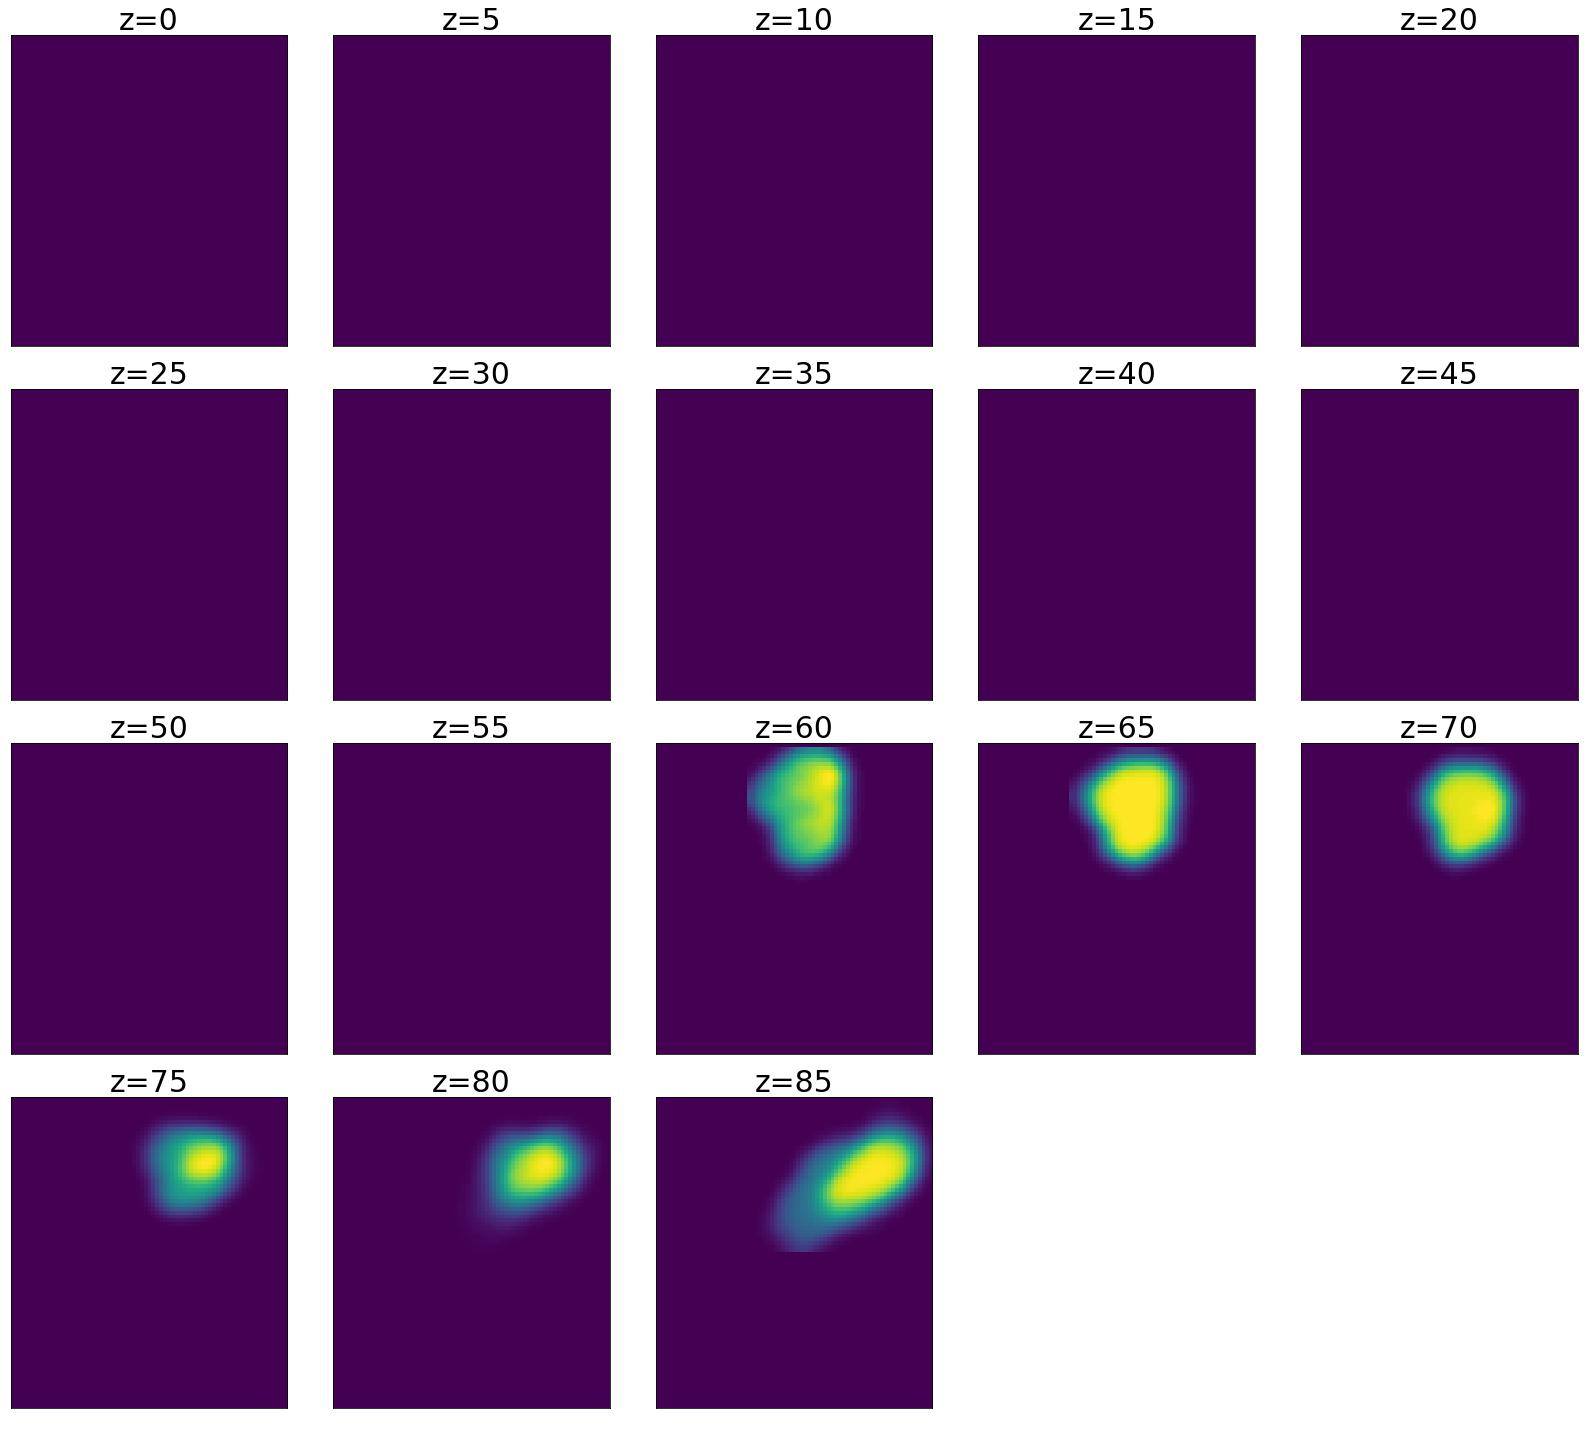

In [46]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox), start_level=0)

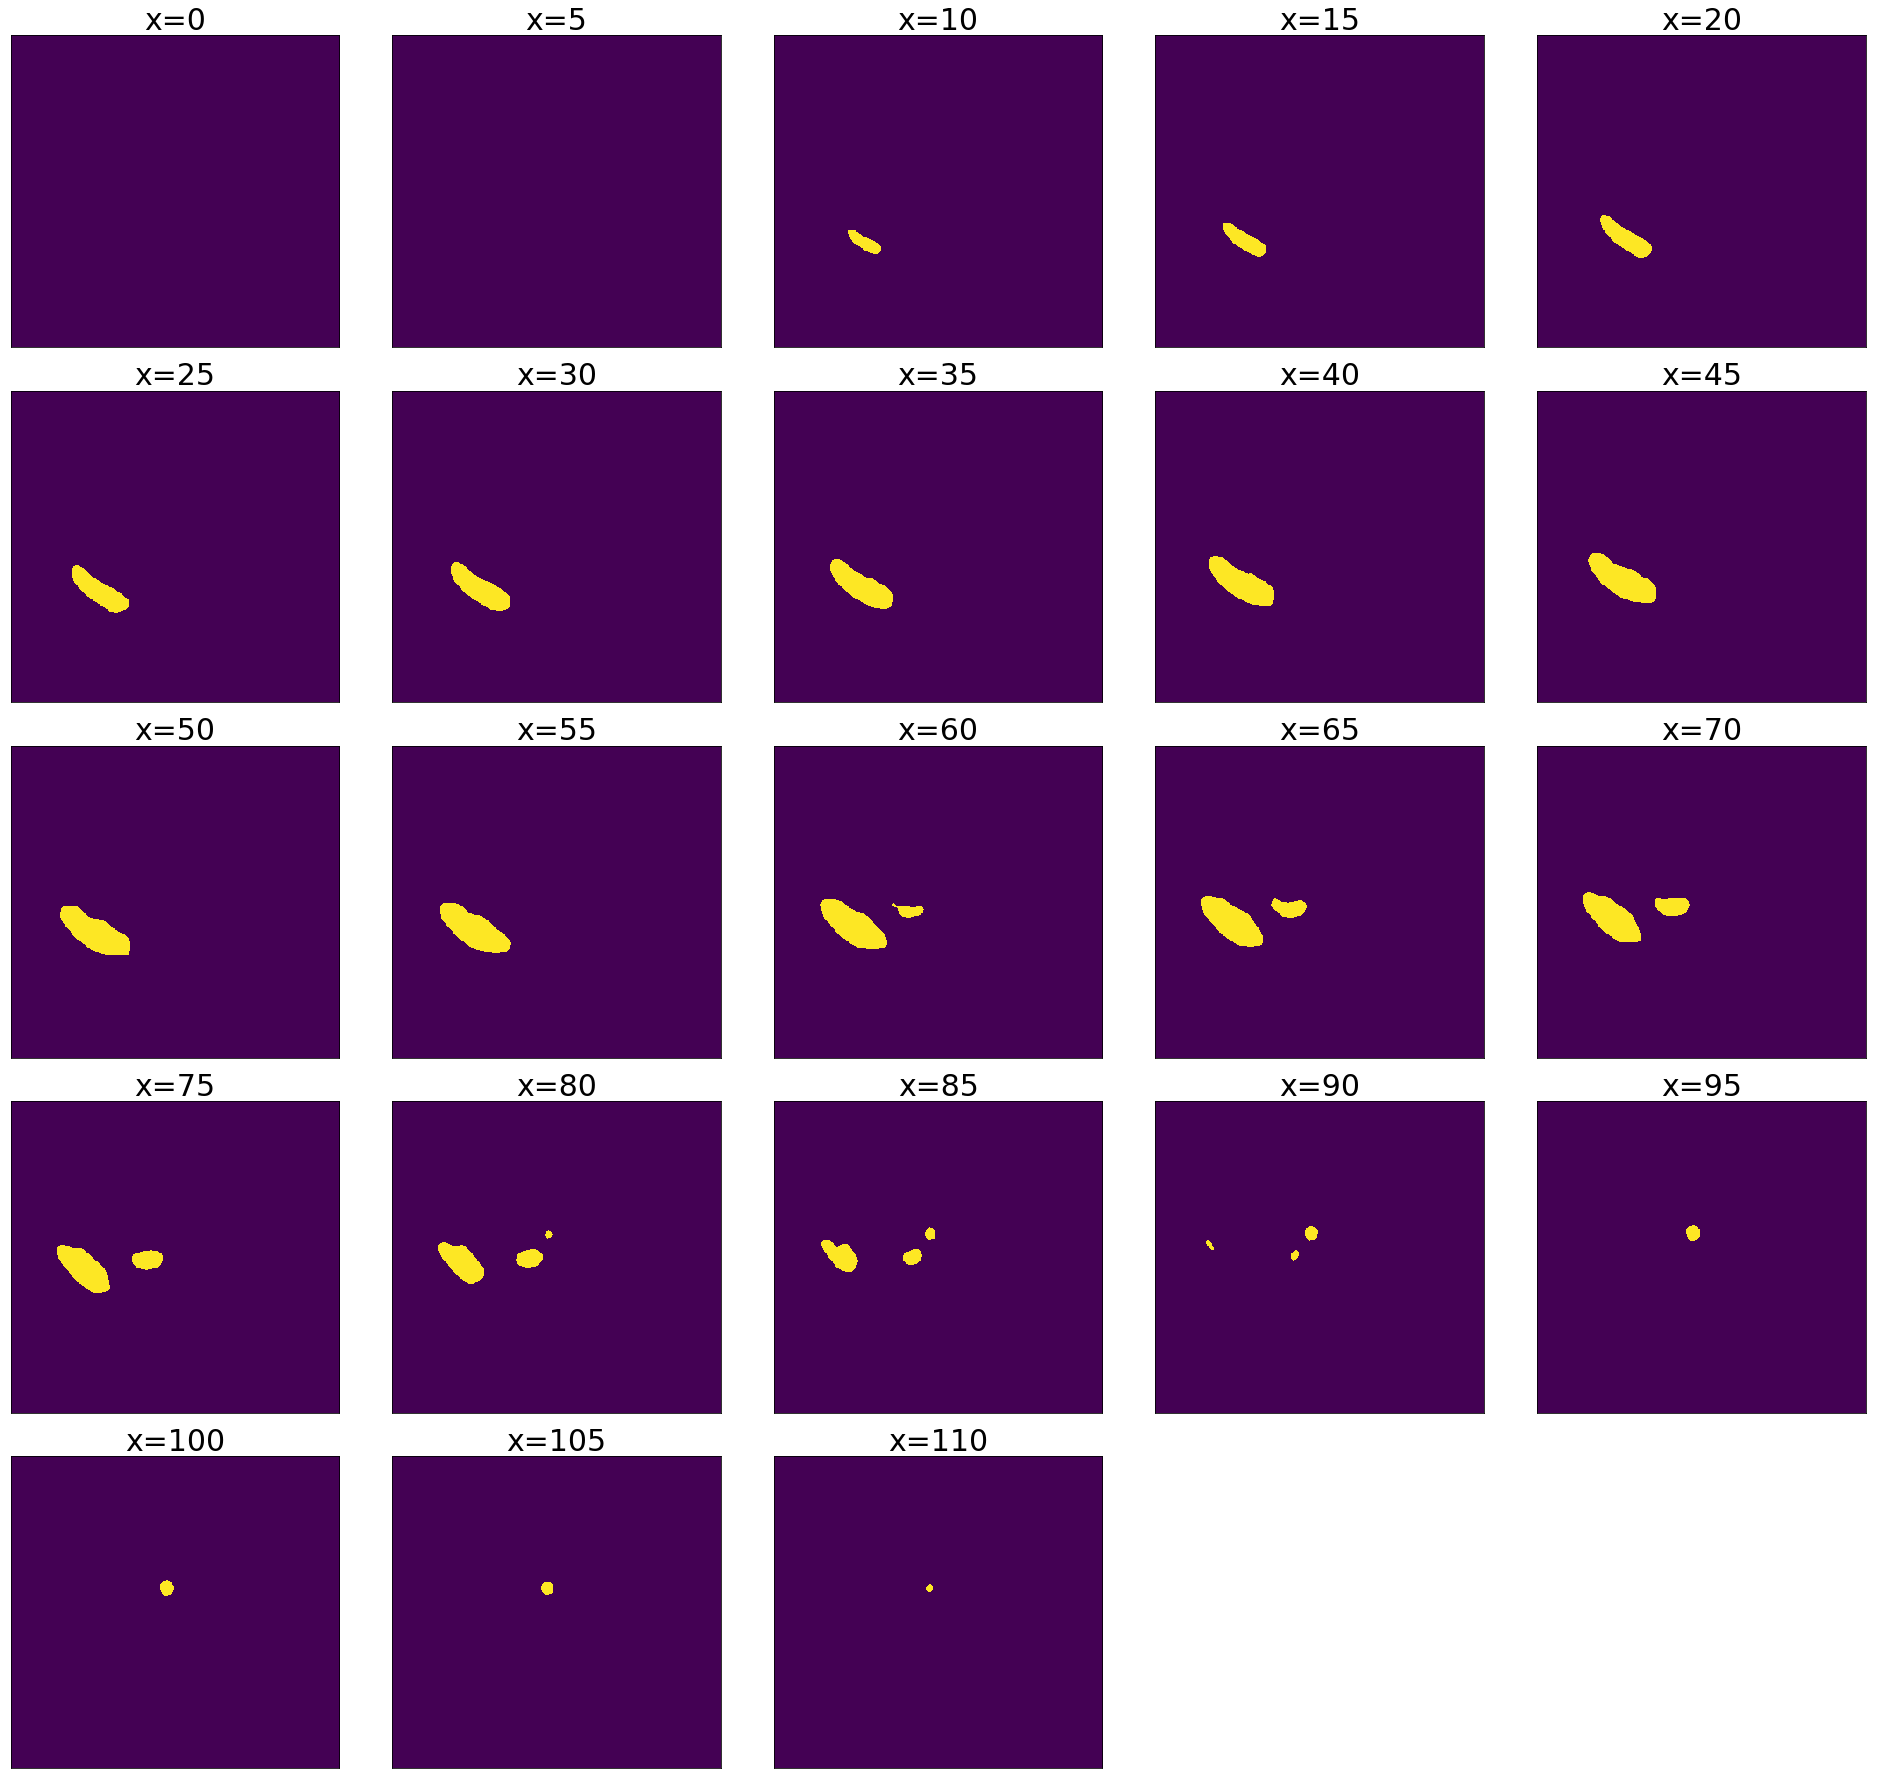

In [204]:
display_volume_sections((volume_moving[59] > .5)|(volume_moving[7]>.5)|(volume_moving[71]>.5), start_level=0, 
                        direction='x')

# Local

In [30]:
warp_setting = 17

In [31]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                         16
transform_type                        rigid
terminate_thresh                      1e-06
grad_computation_sample_number       100000
grid_search_sample_number             10000
std_tx_um                               200
std_ty_um                               200
std_tz_um                               200
std_theta_xy_degree                      30
surround_weight                     inverse
regularization_weight                     0
comment                           local reg
Name: 17, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [32]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
MAX_GRID_SEARCH_ITER_NUM = 30

In [33]:
lr1 = 10
lr2 = 0.1

In [42]:
structure = 'RMC_L'

In [43]:
include_surround = False

In [44]:
from registration_utilities import *

In [45]:
if include_surround:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                                                 structures=[structure])

# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

if surround_weight == 'inverse':
#             if 'volume_moving_structure_sizes' not in locals():
    volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}
    label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                       /float(volume_moving_structure_sizes[label_m])
                       if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
    label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
else:
    sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

aligner = Aligner4(volume_fixed, volume_moving, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [  66.74386219  182.91130091  147.95479637], centroid_f: [ 33.34125936  32.51915456  52.12417437]


In [46]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [47]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [48]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([2])
load gradient 2: 0.010267 seconds
overall: 0.010308 seconds


In [49]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.005)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
sample: 0.00 s
0.002271, [  -22.62187645   -11.89659029    -4.30981994   480.23030251 -1030.91113374
   328.00474003]
step: 0.03 seconds
current score: 0.002271
new_T: [-0.98996692 -0.99993333 -1.00996642]
det: 1.00

iteration 1
sample: 0.00 s
0.002271, [ -15.54617107   -1.98917896   -4.1913186   -30.40423706 -667.26901889
  425.21936283]
step: 0.03 seconds
current score: 0.002271
new_T: [-1.55378195 -1.16730578 -1.70863028]
det: 1.00

iteration 2
sample: 0.00 s
0.002273, [ -13.40671957   -2.26649567   -3.39825869    7.13477299 -579.08750921
  347.98012733]
step: 0.03 seconds
current score: 0.002273
new_T: [-1.99110259 -1.3531354  -2.20166647]
det: 1.00

iteration 3
sample: 0.00 s
0.002274, [ -1.13769011e+01   3.59856784e-01  -2.36811474e+00  -9.33256799e+01
  -5.08726884e+02   3.68789336e+02]
step: 0.03 seconds
current score: 0.002274
new_T: [-2.33961385 -1.3250063  -2.52668079]
det: 1.00

iteration 4
sample: 0.00 s
0.002274, [ -1.11106901e+01  -2.21300125e-01  -1.4644454

sample: 0.00 s
0.002193, [ -2.60515809e+00   5.06630838e-01  -1.00073218e-02  -3.13773474e+01
  -1.32594248e+02   1.01808878e+02]
step: 0.03 seconds
current score: 0.002193
new_T: [-6.52548791  0.31285726 -5.46183309]
det: 1.00

iteration 37
sample: 0.00 s
0.002180, [ -2.20527202   0.25307134  -0.69864124 -38.48636985 -89.0252164
  74.38222647]
step: 0.03 seconds
current score: 0.002180
new_T: [-6.57378713  0.3307605  -5.53627175]
det: 1.00

iteration 38
sample: 0.00 s
0.002170, [  -3.04930419    0.58136031   -1.39768928  -81.88283622 -117.98917204
  116.95345491]
step: 0.03 seconds
current score: 0.002170
new_T: [-6.64041476  0.37181567 -5.68358154]
det: 1.00

iteration 39
sample: 0.00 s
0.002158, [  -3.09470326   -0.49930841   -0.45667559    6.53722197 -147.60620713
   77.60531634]
step: 0.03 seconds
current score: 0.002158
new_T: [-6.70787738  0.33646023 -5.73166878]
det: 1.00

iteration 40
sample: 0.00 s
0.002138, [ -1.61003977   0.51126838  -1.20958418 -70.62777221 -52.71352708
  

0.001677, [ -1.7228052    0.0912863   -0.1140672  -11.23407304 -75.9537828
  59.63013232]
step: 0.03 seconds
current score: 0.001677
new_T: [-8.02426797  0.86397047 -6.59465416]
det: 1.00

iteration 74
sample: 0.00 s
0.001662, [ -2.29826689e+00   9.41339135e-02   5.06793559e-01   1.46282637e+01
  -1.37586681e+02   7.51978639e+01]
step: 0.03 seconds
current score: 0.001662
new_T: [-8.07295291  0.87040239 -6.54525647]
det: 1.00

iteration 75
sample: 0.00 s
0.001648, [ -1.62989169   0.32129198   0.28972417  -9.23114419 -93.39272082
  58.09600174]
step: 0.03 seconds
current score: 0.001648
new_T: [-8.10745713  0.89240585 -6.51702838]
det: 1.00

iteration 76
sample: 0.00 s
0.001633, [ -1.78781211e+00  -6.91156089e-01   6.47628307e-02   3.66477889e+01
  -9.67647001e+01   3.34178647e+01]
step: 0.03 seconds
current score: 0.001633
new_T: [-8.14526162  0.84510811 -6.51073699]
det: 1.00

iteration 77
sample: 0.00 s
0.001613, [ -1.11235857   1.43348783   0.39899111 -65.56374192 -69.54917818
  85.

sample: 0.00 s
0.001451, [ -0.0900659   -0.64356029   0.35050035  42.72613853 -20.71491212
 -18.29777777]
step: 0.03 seconds
current score: 0.001451
new_T: [-8.51192921  0.95349513 -6.638428  ]
det: 1.00

iteration 112
sample: 0.00 s
0.001452, [ -0.45301437  -0.47278494  -1.09698147 -13.03897083   7.74778247
   1.68472856]
step: 0.03 seconds
current score: 0.001452
new_T: [-8.52144253  0.92266655 -6.73841397]
det: 1.00

iteration 113
sample: 0.00 s
0.001454, [ -0.13058335   1.17964357   0.40427953 -55.73280931 -20.36099464
  51.57871306]
step: 0.03 seconds
current score: 0.001454
new_T: [-8.52419975  0.99935201 -6.70161695]
det: 1.00

iteration 114
sample: 0.00 s
0.001449, [  0.59384912   0.33699453   1.24863714  16.07753545  -5.96184164
  -1.35310382]
step: 0.03 seconds
current score: 0.001449
new_T: [-8.51173343  1.02123847 -6.58860826]
det: 1.00

iteration 115
sample: 0.00 s
0.001451, [ -4.11276519e-01  -1.08892679e+00   5.01179695e-02   5.55082548e+01
  -2.51445758e+01  -1.72974524

new_T: [-8.69380624  1.00540066 -6.76554258]
det: 1.00

iteration 149
sample: 0.00 s
0.001354, [  0.47351718   0.27092993   0.38597345 -14.03734356   5.46741486
   4.62435901]
step: 0.03 seconds
current score: 0.001354
new_T: [-8.6838961   1.02246526 -6.73249303]
det: 1.00

iteration 150
sample: 0.00 s
0.001364, [ -0.08315027   0.0336425   -0.73305666 -32.47750193   8.98600549
  15.56016505]
step: 0.03 seconds
current score: 0.001364
new_T: [-8.6856377  1.0245713 -6.7951422]
det: 1.00

iteration 151
sample: 0.00 s
0.001361, [  0.52998126  -0.49450815   0.55796921  36.84289098   4.43820655
 -29.00276452]
step: 0.03 seconds
current score: 0.001361
new_T: [-8.67454931  0.99343334 -6.74751807]
det: 1.00

iteration 152
sample: 0.00 s
0.001369, [ -0.30445039   0.11142299  -0.2332601  -21.73525214  -9.14303094
  16.78577721]
step: 0.03 seconds
current score: 0.001369
new_T: [-8.68092046  1.00044351 -6.76742753]
det: 1.00

iteration 153
sample: 0.00 s
0.001362, [  0.49027741   0.40883571   0.2

sample: 0.00 s
0.001485, [  0.22243917   0.44959724  -0.33284515 -36.30583137  13.23602557
   8.39410901]
step: 0.03 seconds
current score: 0.001485
new_T: [-8.4208315   0.96391227 -6.62419542]
det: 1.00

iteration 187
sample: 0.00 s
0.001493, [ -0.29851109  -0.03457814   0.45106173  14.40110564 -27.46969163
  10.79318136]
step: 0.03 seconds
current score: 0.001493
new_T: [-8.42705717  0.96179647 -6.58748449]
det: 1.00

iteration 188
sample: 0.00 s
0.001491, [ -0.51126838  -0.1376617   -0.79049706 -20.6148389  -10.79318136
   9.18761641]
step: 0.03 seconds
current score: 0.001491
new_T: [-8.43771383  0.95337864 -6.65168879]
det: 1.00

iteration 189
sample: 0.00 s
0.001489, [  0.80164343  -0.27328938   0.77992022  34.3511492    8.46375346
 -32.28305072]
step: 0.03 seconds
current score: 0.001489
new_T: [-8.42100481  0.93667121 -6.58847322]
det: 1.00

iteration 190
sample: 0.00 s
0.001491, [ -0.20209908   0.25937676  -0.20852655 -25.35302103  -7.76584446
  13.97998452]
step: 0.03 seconds

0.001494, [ 0.2687332   0.29411763  0.53909361 -1.59279138 -4.19965804  7.74639934]
step: 0.03 seconds
current score: 0.001494
new_T: [-8.41157882  0.95012556 -6.616917  ]
det: 1.00

iteration 224
sample: 0.00 s
0.001494, [   1.7074281    -0.58498085   -0.57407856    6.76852942  100.53233474
  -66.54291362]
step: 0.03 seconds
current score: 0.001494
new_T: [-8.37620726  0.91542212 -6.6623502 ]
det: 1.00

iteration 225
sample: 0.00 s
0.001514, [  1.11463666e-02  -2.71824896e-01   3.06647122e-01   1.25478798e+01
  -1.22817501e+01  -5.86665004e+00]
step: 0.03 seconds
current score: 0.001514
new_T: [-8.37597721  0.89929955 -6.6380951 ]
det: 1.00

iteration 226
sample: 0.00 s
0.001516, [  0.50549179  -0.88772267  -0.123505    30.56439489  24.09250528
 -45.01065552]
step: 0.03 seconds
current score: 0.001516
new_T: [-8.36550903  0.84672534 -6.64787392]
det: 1.00

iteration 227
sample: 0.00 s
0.001519, [  0.4504922   -0.43625414  -0.80961674  -7.71409929  51.25253946
 -23.5006088 ]
step: 0.03

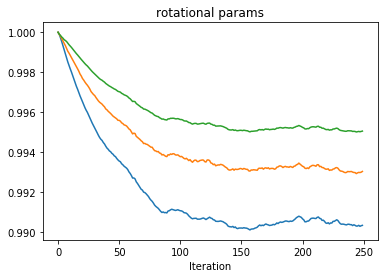

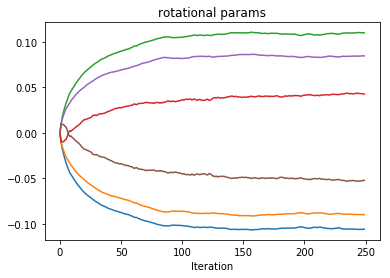

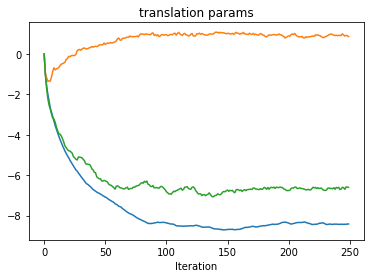

In [50]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.002289 0.001491
[[  9.98721392e-01  -4.02708779e-02  -3.05587655e-02  -3.09496589e+00]
 [  4.02972669e-02   9.99187704e-01   2.47929574e-04  -8.59766700e-01]
 [  3.05239585e-02  -1.47904730e-03   9.99532941e-01  -3.17685960e+00]]


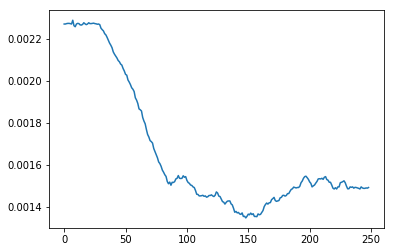

In [51]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [52]:
label_mapping_m2f

{1: 2}

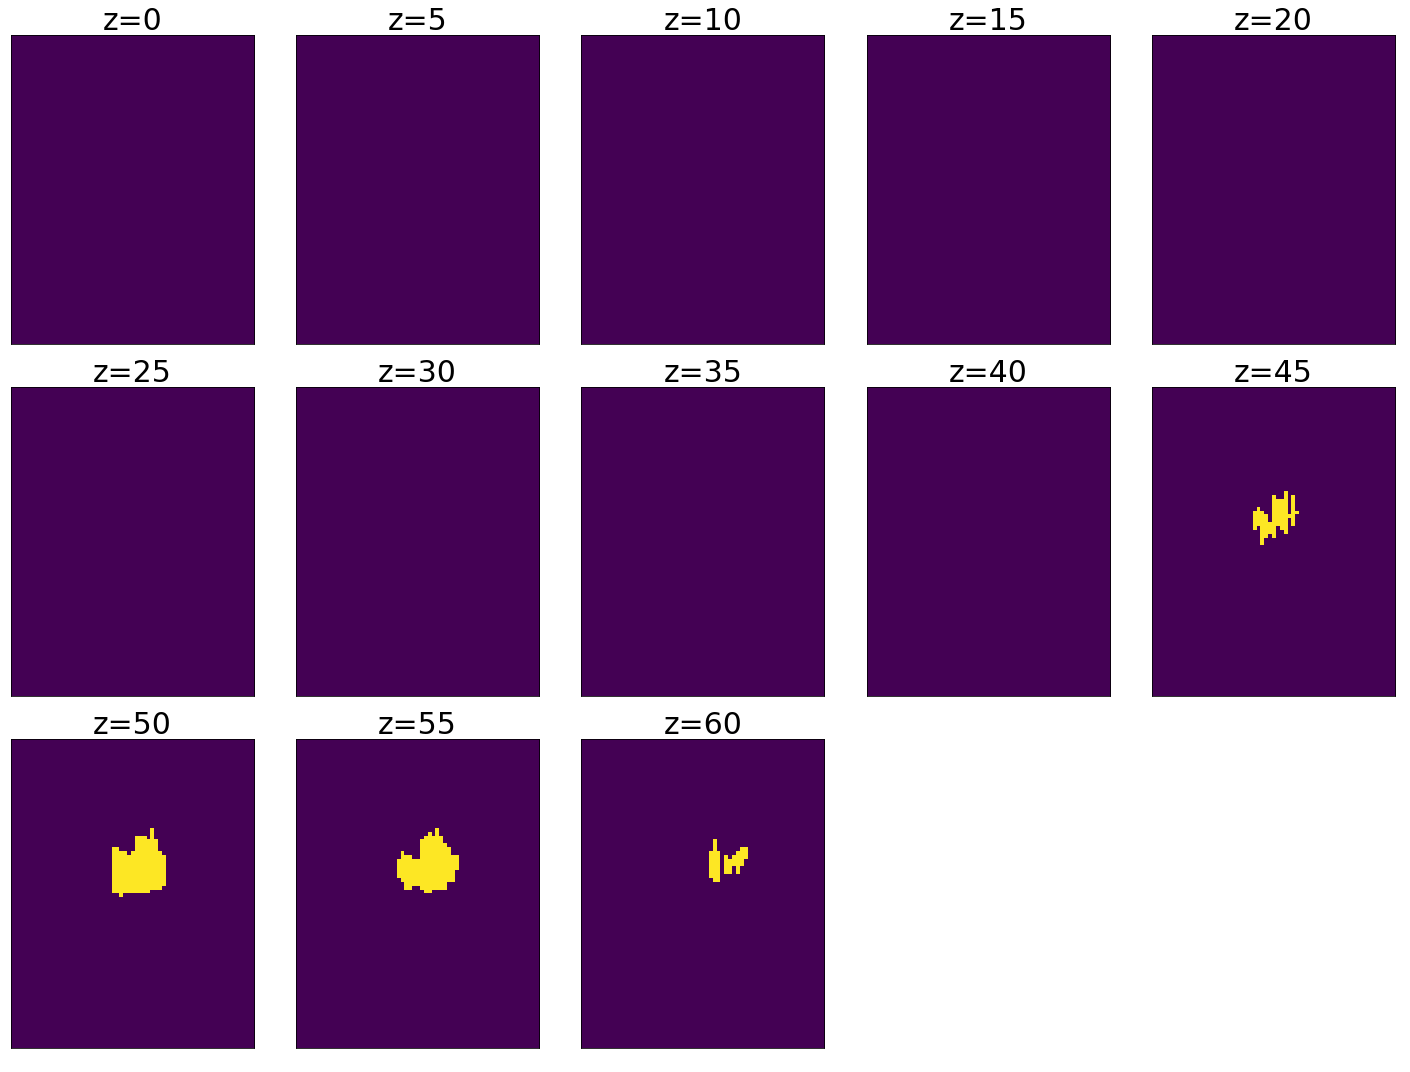

In [54]:
display_volume_sections(volume_fixed[2], start_level=0, every=5)

In [55]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [56]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

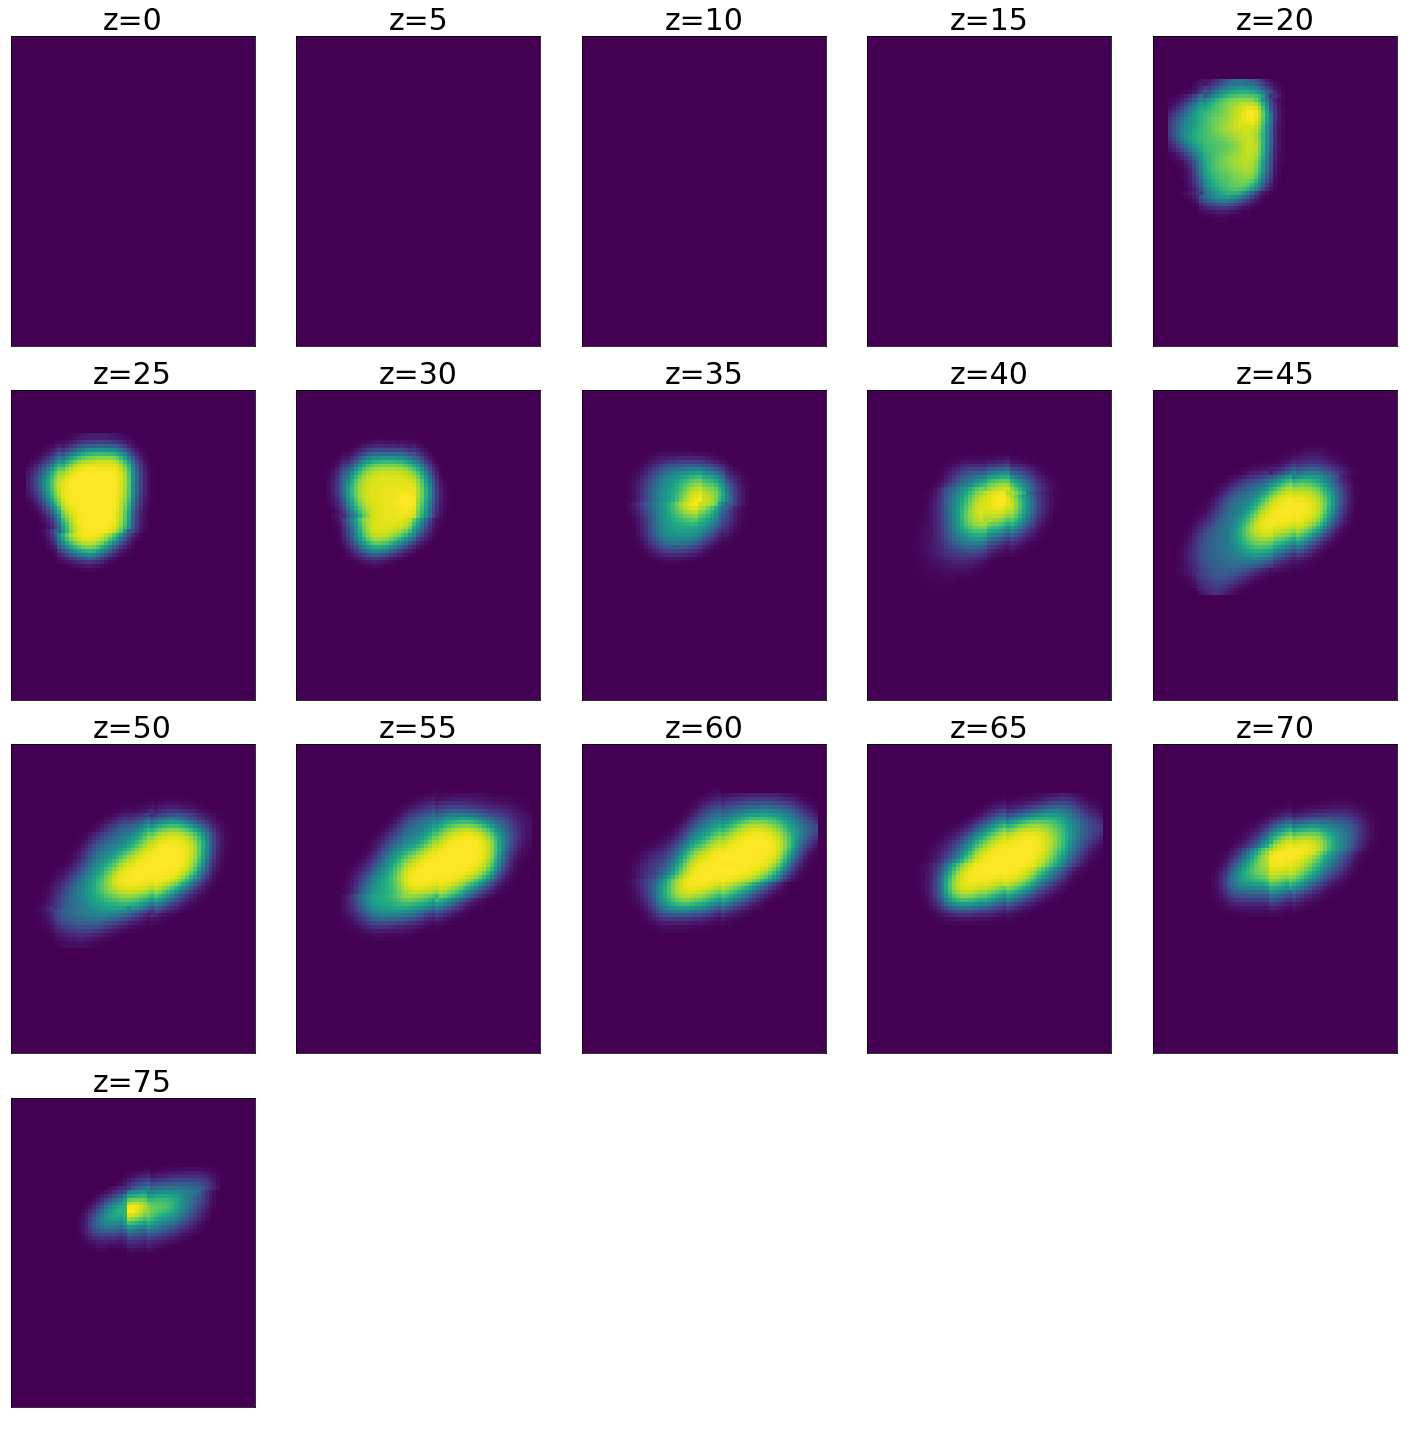

In [57]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0)